## PRUEBA TECNICA DATECSA

ANDRES DAVID CANDELO LOPEZ


CIENTIFICO DE DATOS

### Extraccion de Datos

In [1]:
!pip install sweetviz==2.3.1

In [2]:
import pandas as pd
import zipfile
import os
import requests
from io import BytesIO

def cargar_datos_banco(url):
    # Descargamos el archivo ZIP
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Error al descargar el archivo: {response.status_code}")
    
    # Descomprimir el archivo ZIP
    with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
        # Extraemos todos los archivos en un directorio temporal
        zip_ref.extractall("temp_banco")
    
    # Leer los archivos CSV
    bank_full_path = os.path.join("temp_banco", "bank-full.csv")
    bank_path = os.path.join("temp_banco", "bank.csv")
    
    if not os.path.exists(bank_full_path) or not os.path.exists(bank_path):
        raise Exception("No se encontraron los archivos 'bank-full.csv' y/o 'bank.csv' en el archivo ZIP.")
    
    # Cargar los CSV en pandas
    df_bank_full = pd.read_csv(bank_full_path, delimiter=';')
    df_bank = pd.read_csv(bank_path, delimiter=';')
    
    # Limpiar el directorio temporal
    for f in os.listdir("temp_banco"):
        os.remove(os.path.join("temp_banco", f))
    os.rmdir("temp_banco")
    
    # Retornar los dataframes
    return df_bank_full, df_bank

# Ejemplo de uso
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"
df_bank_full, df_bank = cargar_datos_banco(url)

### EDA

                                             |          | [  0%]   00:00 -> (? left)


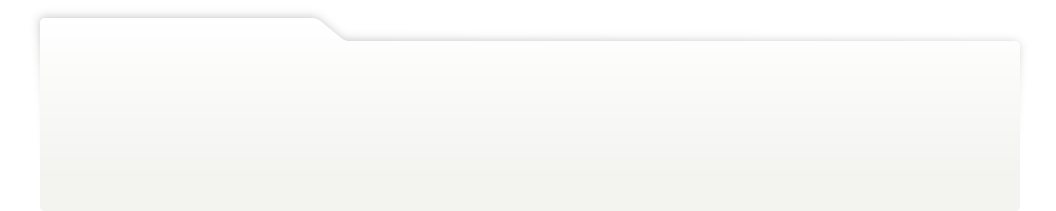
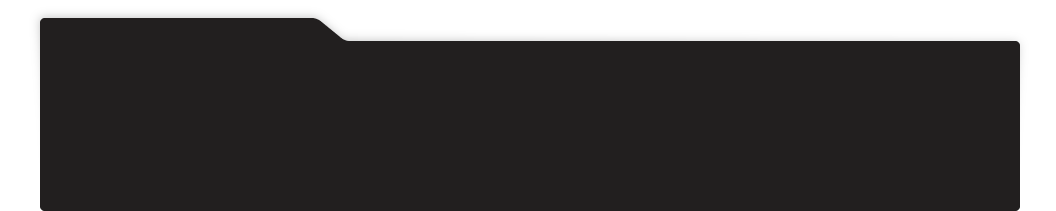
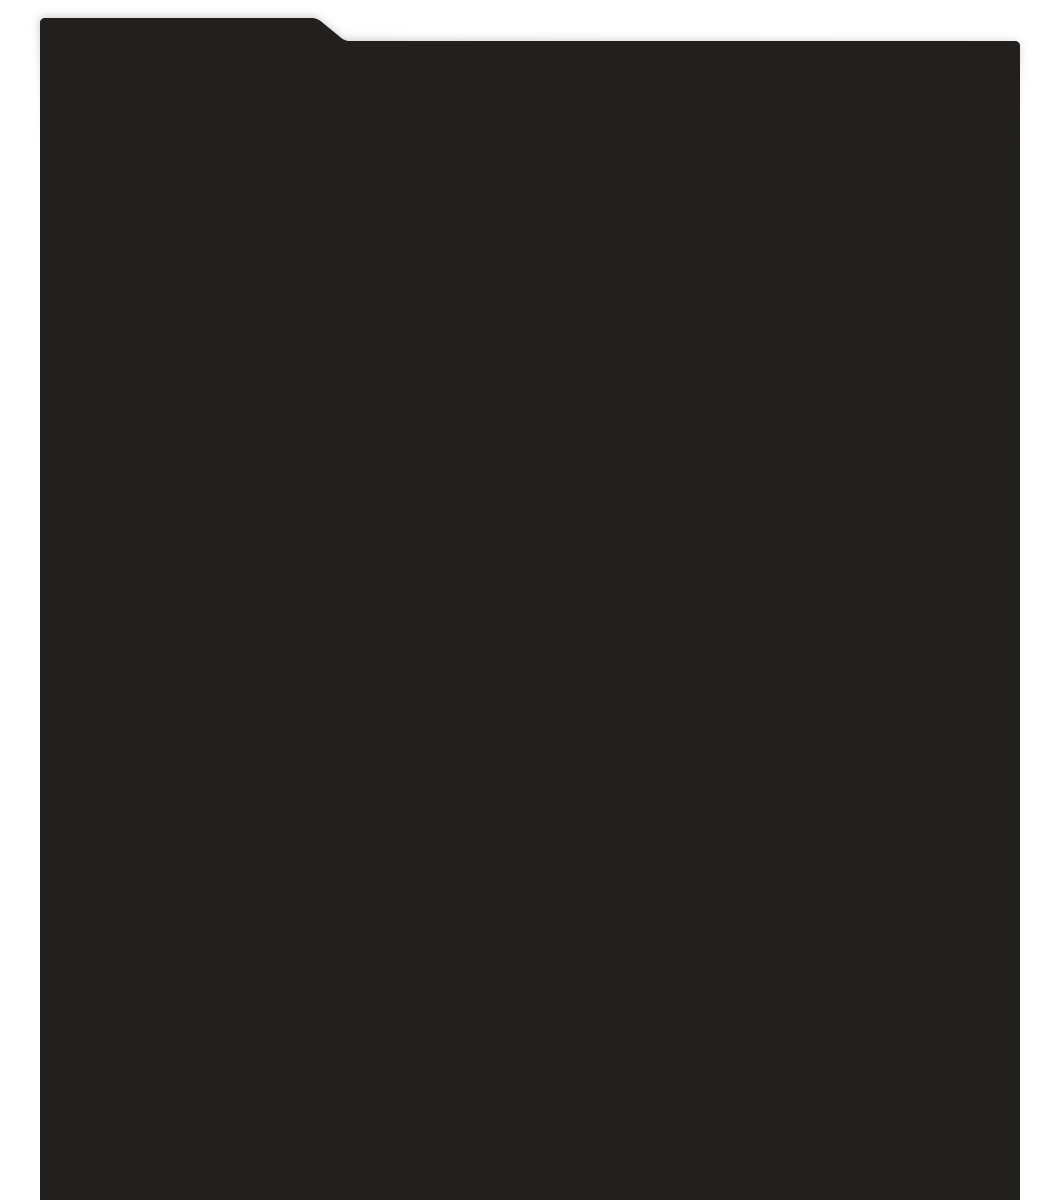
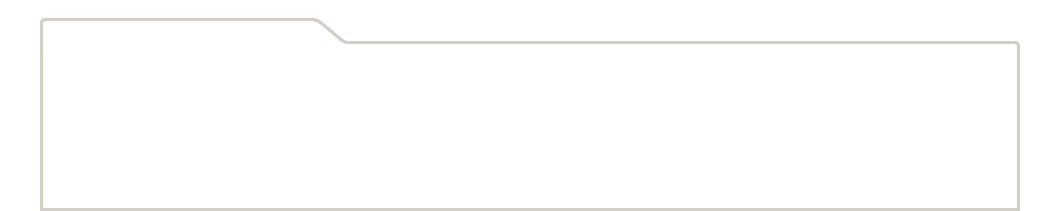
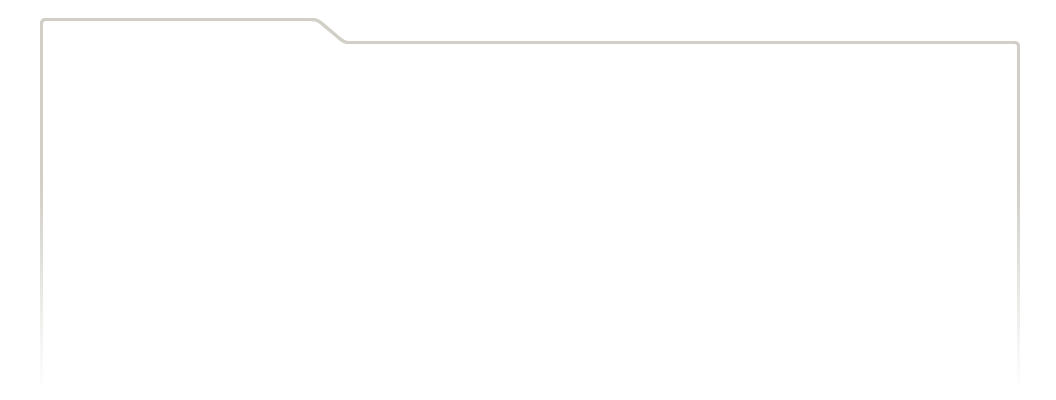
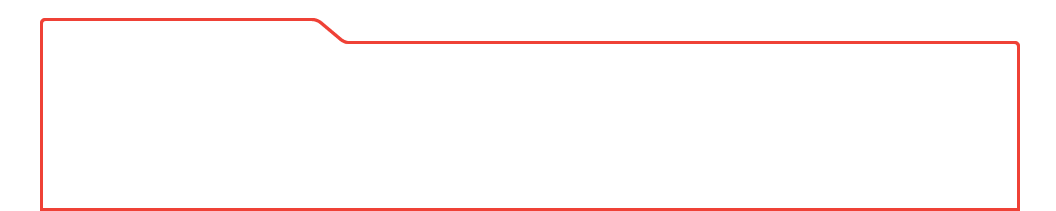
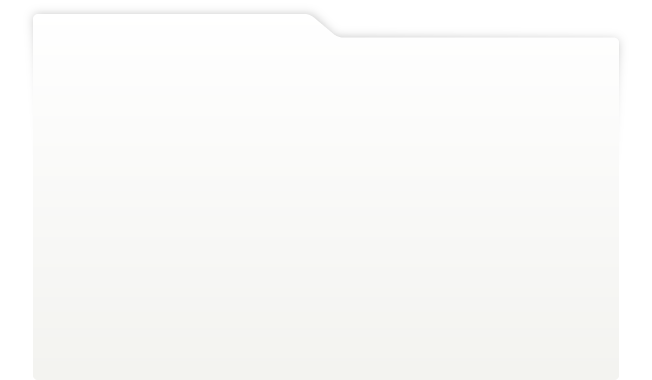
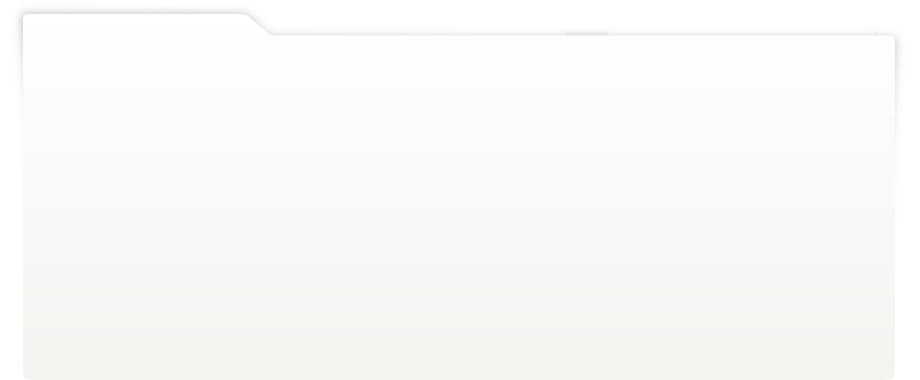
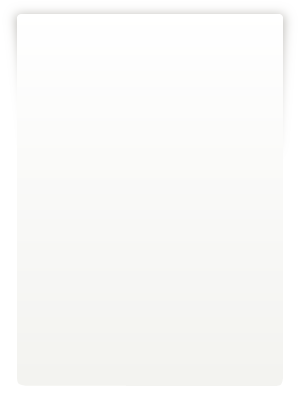
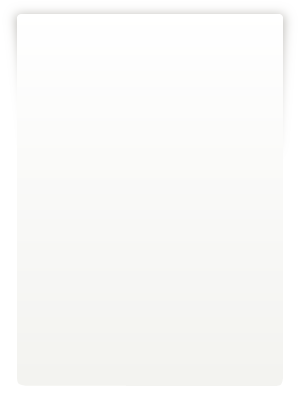
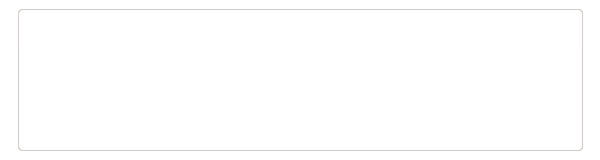
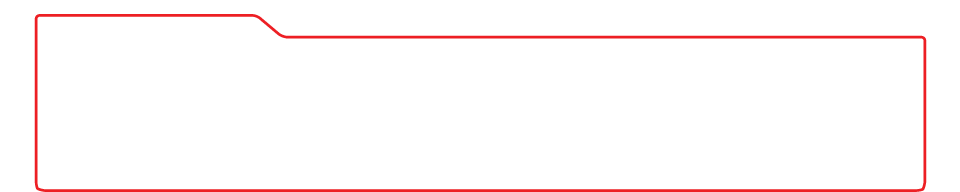
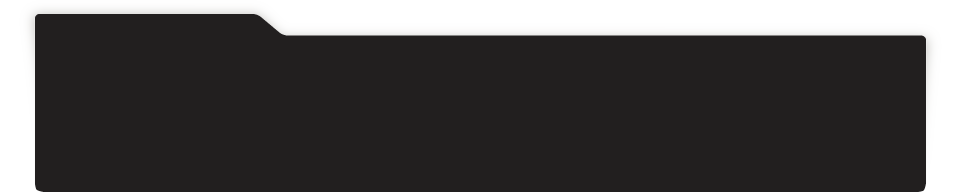
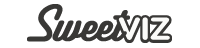
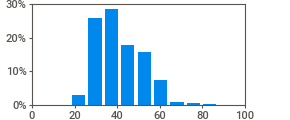
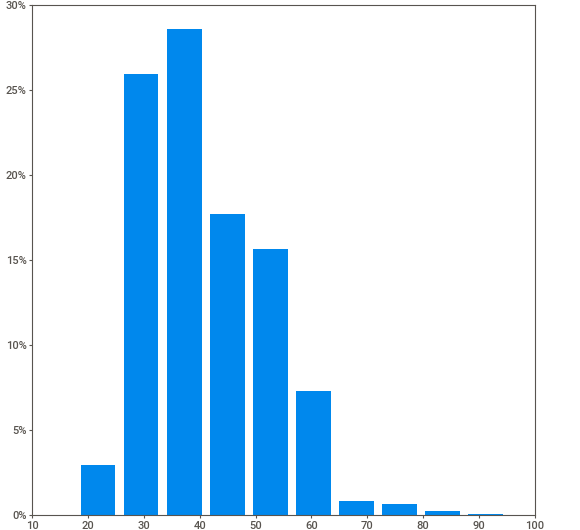
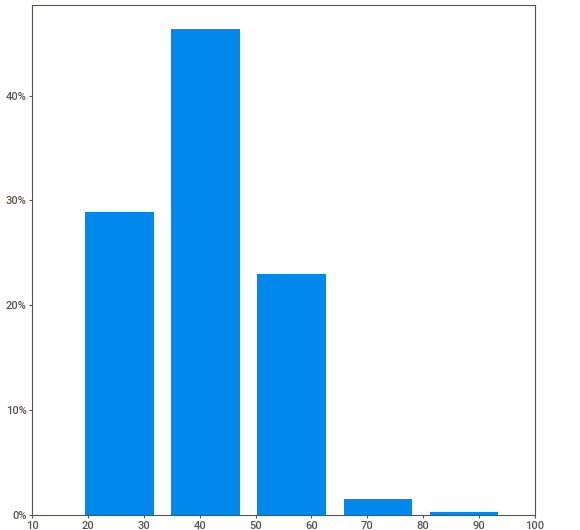
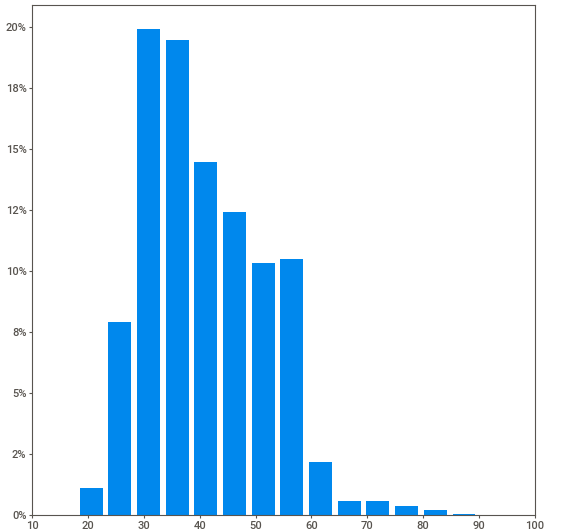
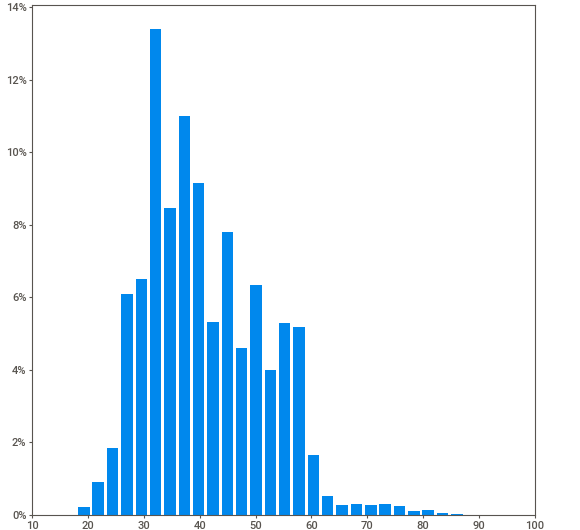
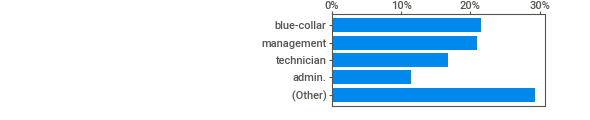
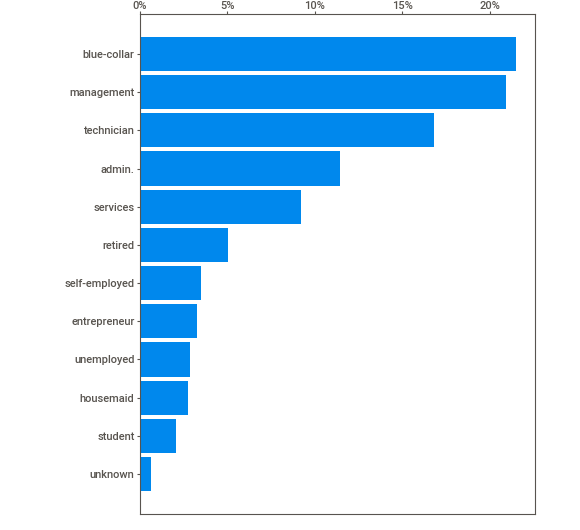
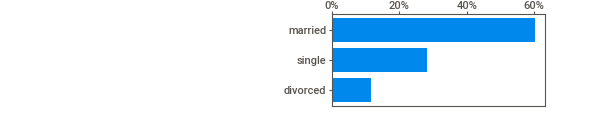
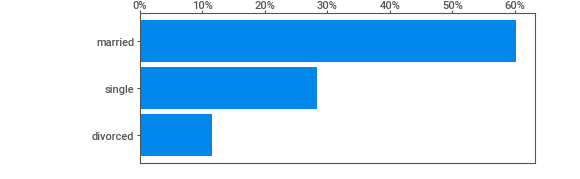
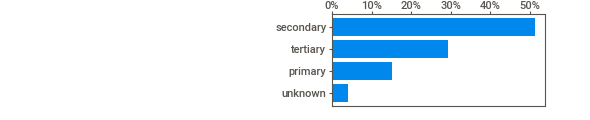
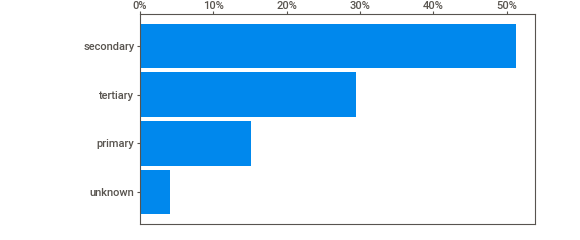
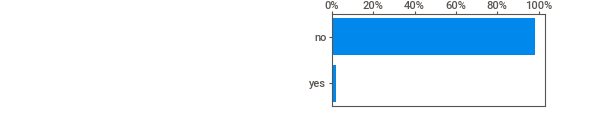
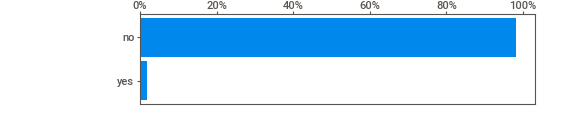
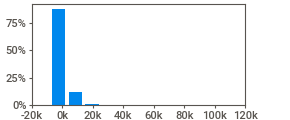
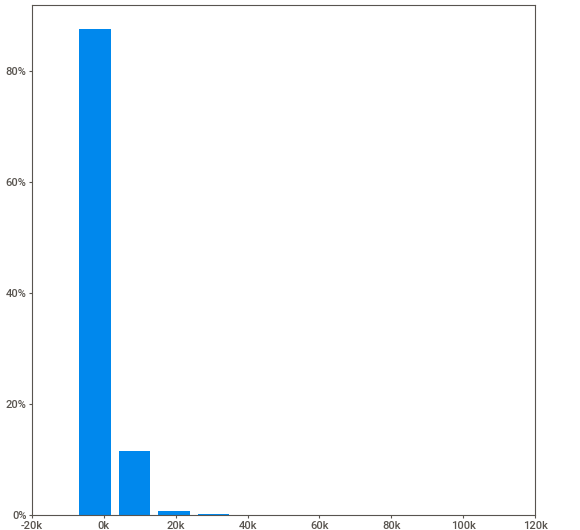
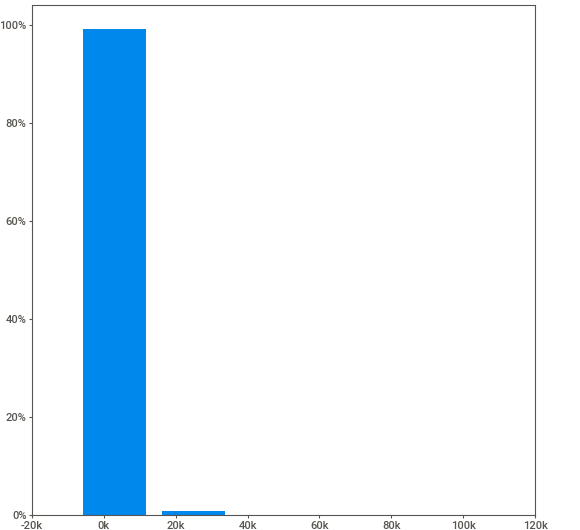
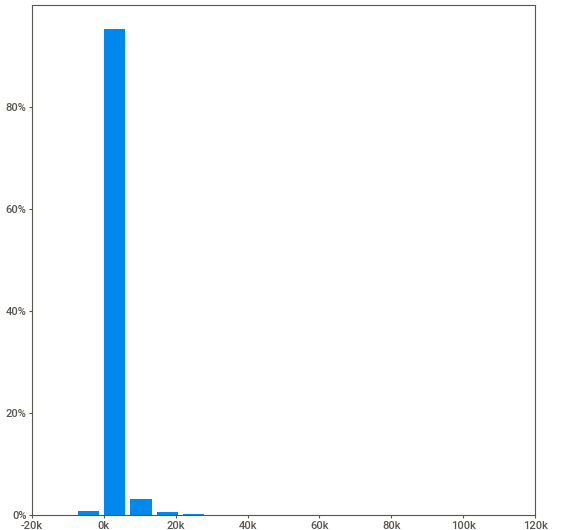
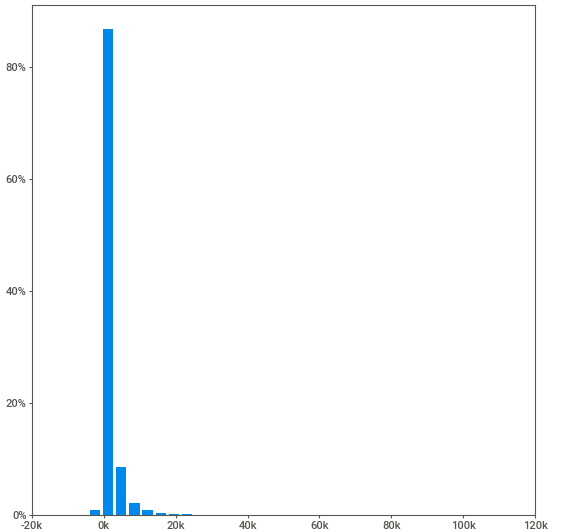
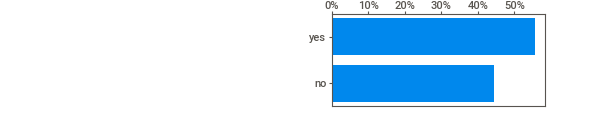
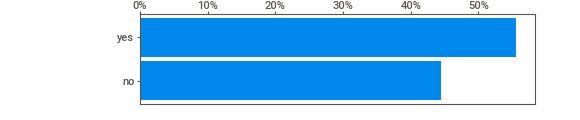
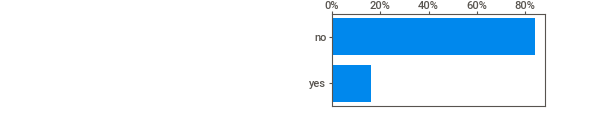
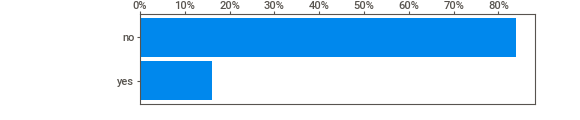
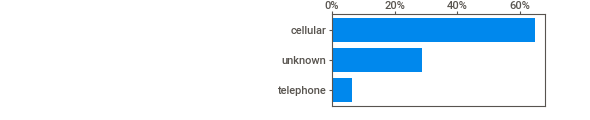
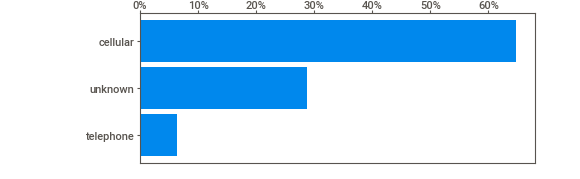
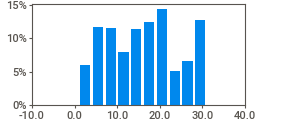
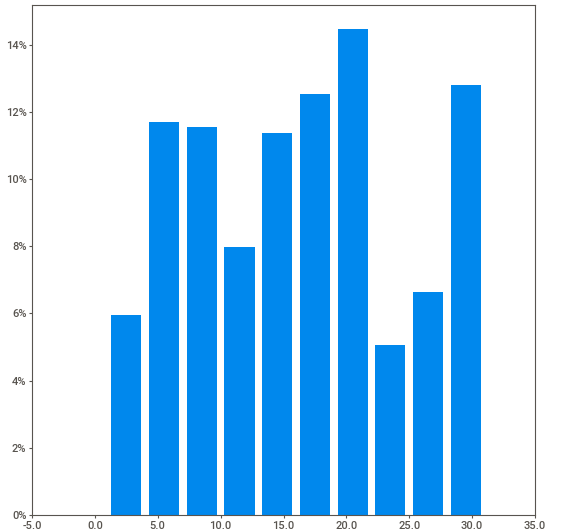
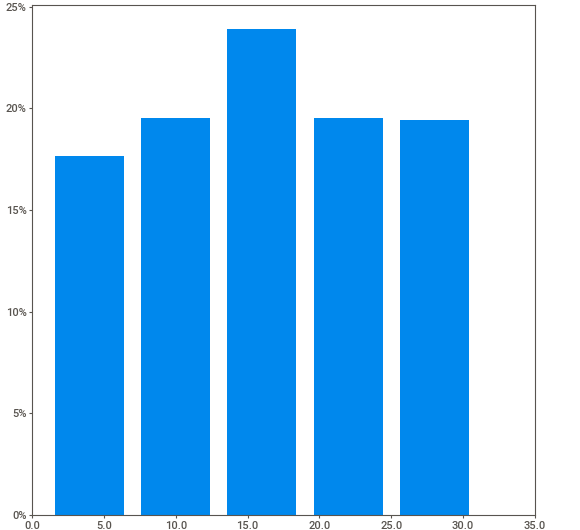
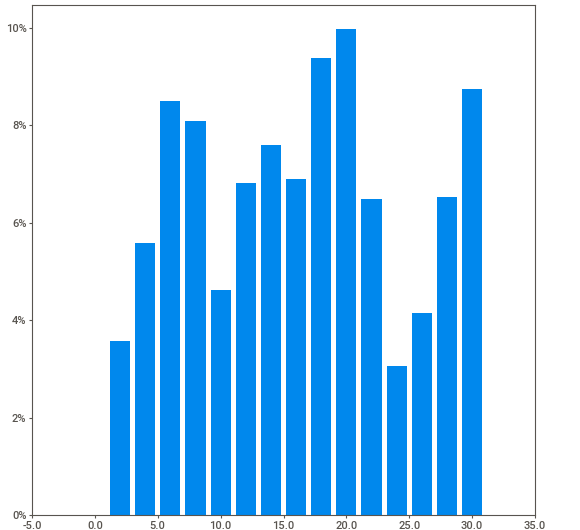
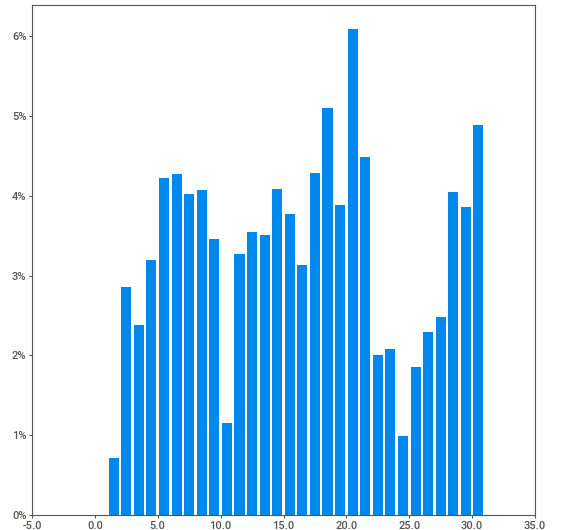
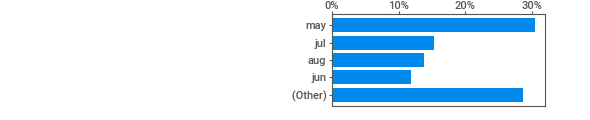
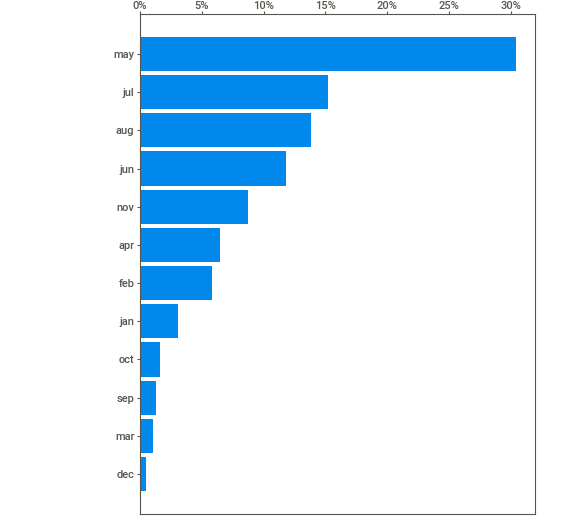
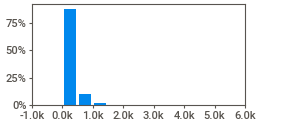
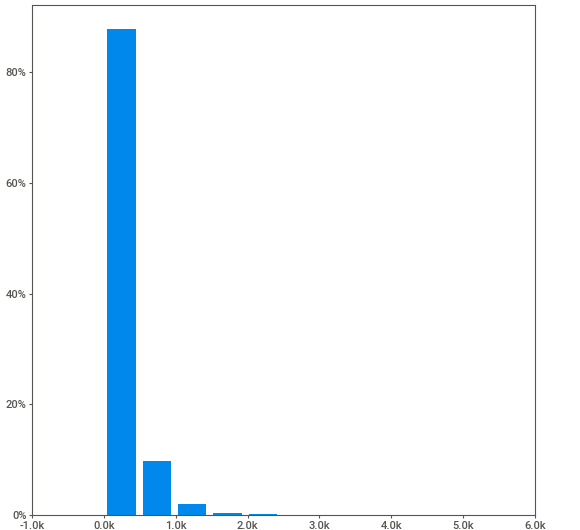
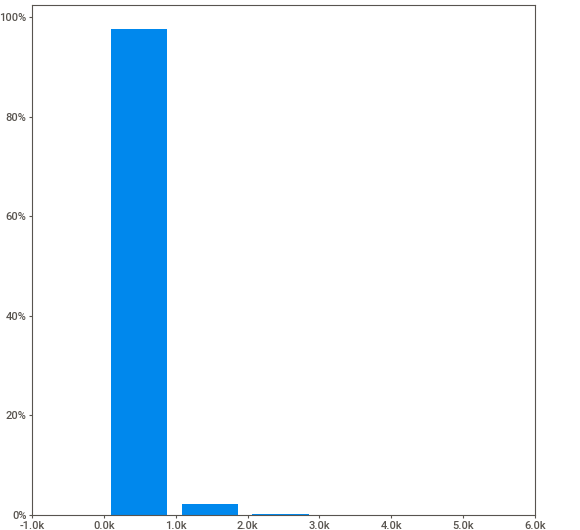
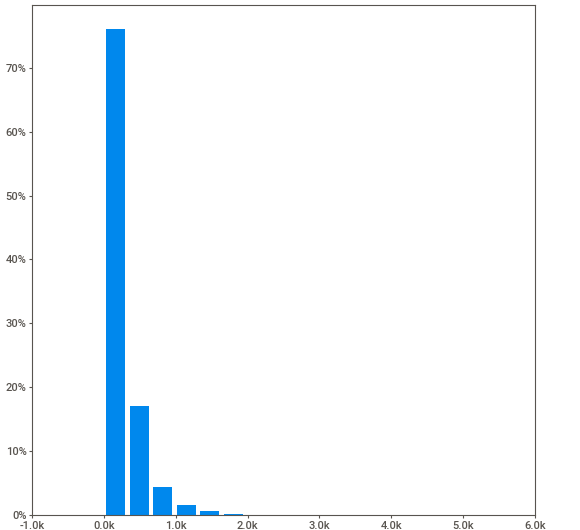
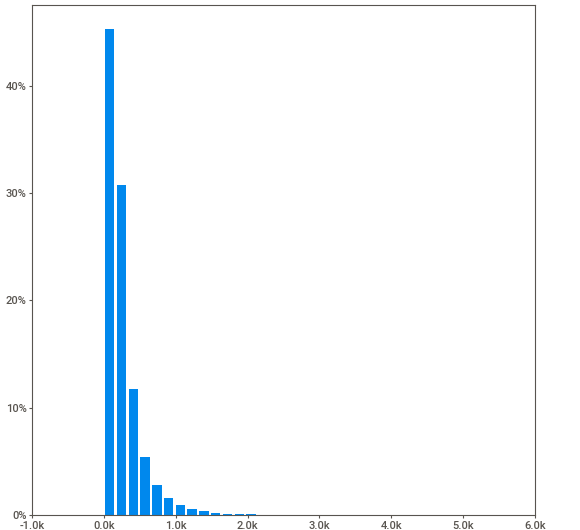
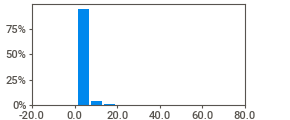
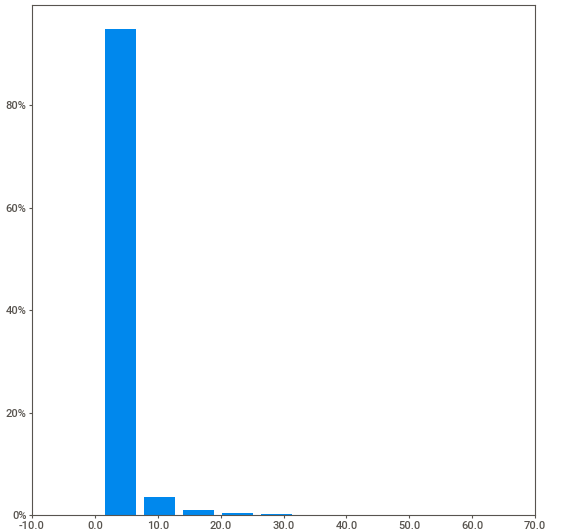
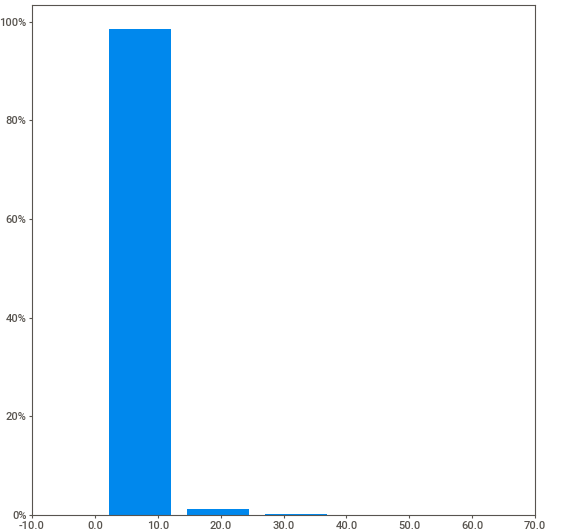
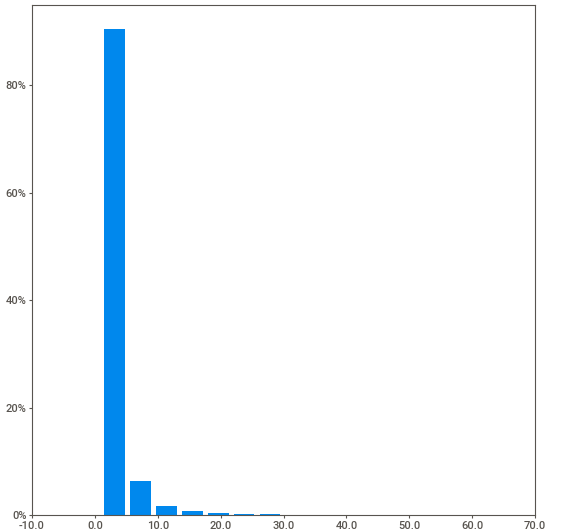
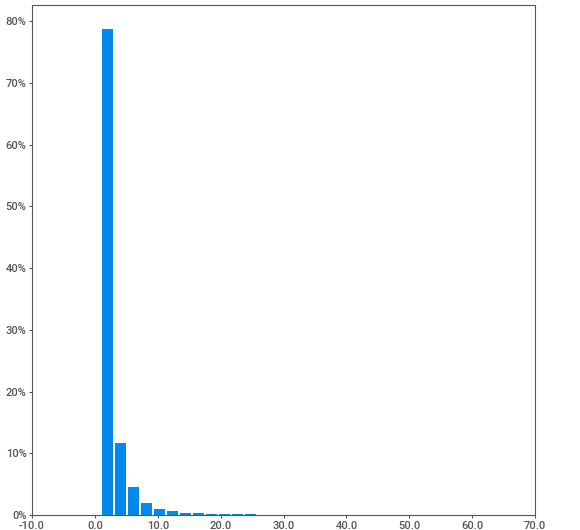
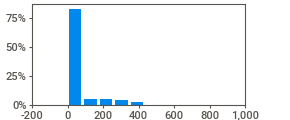
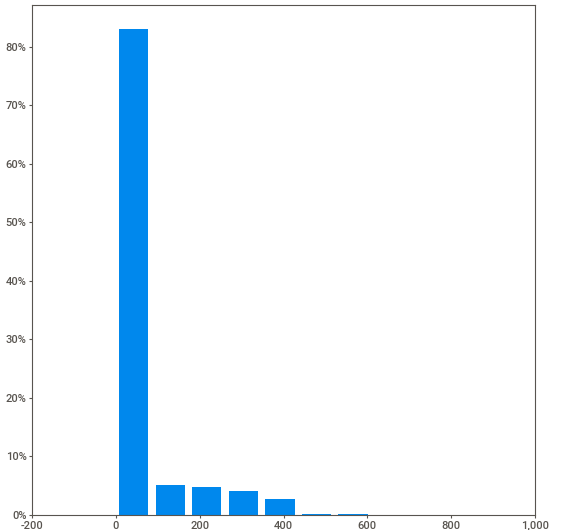
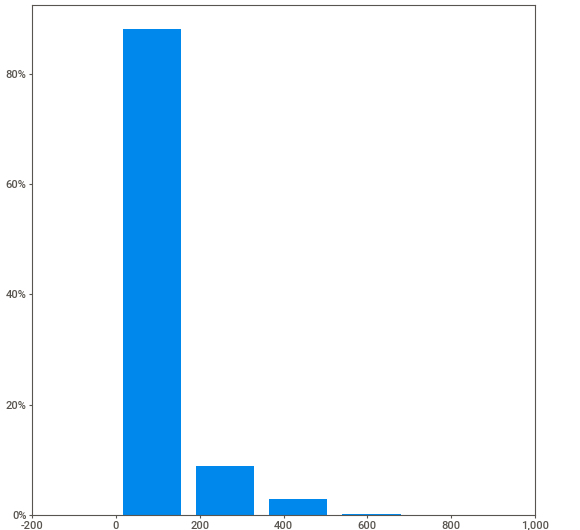
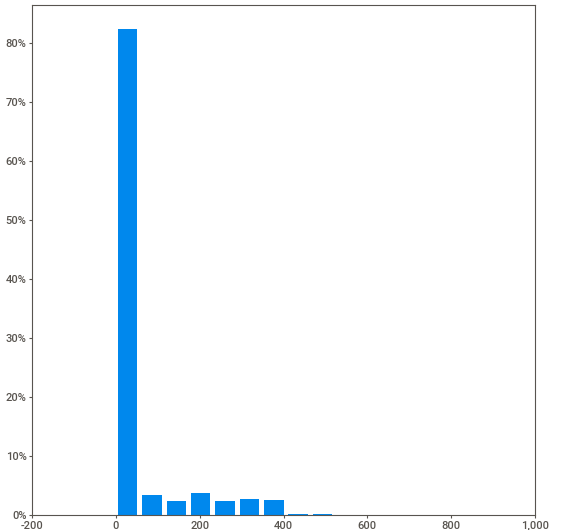
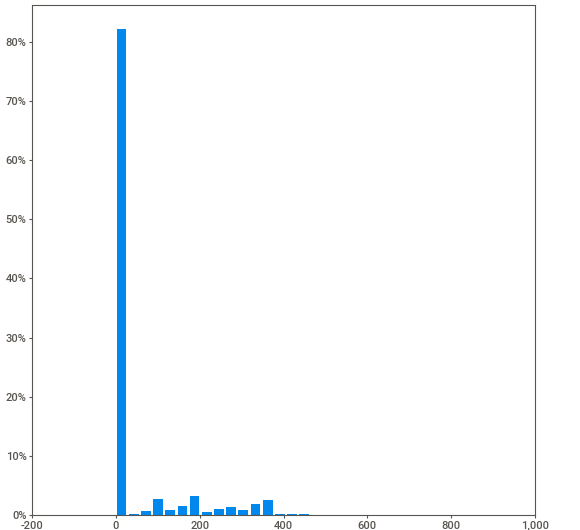
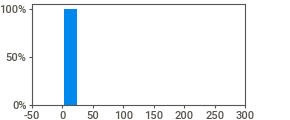
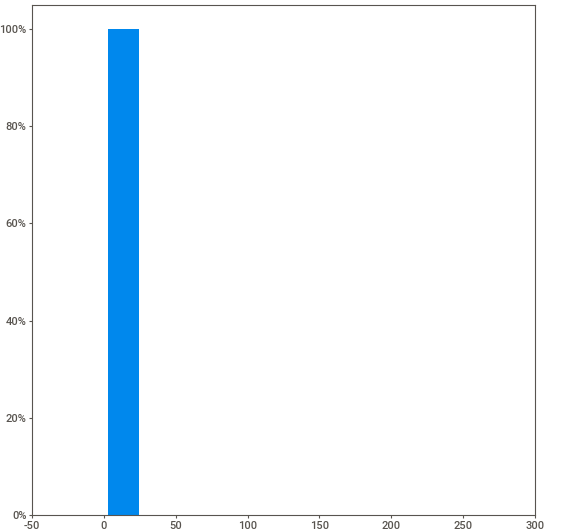
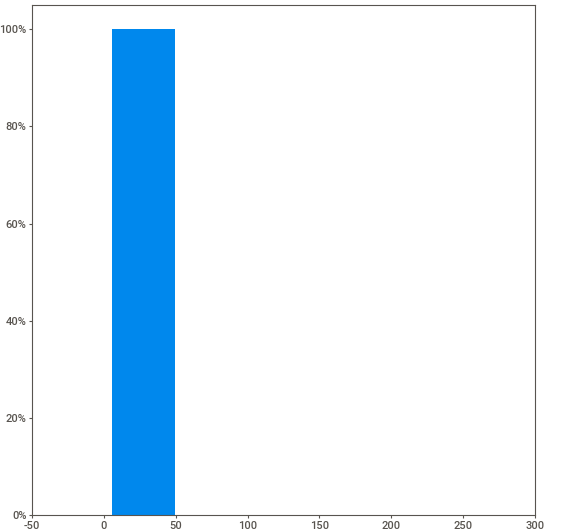
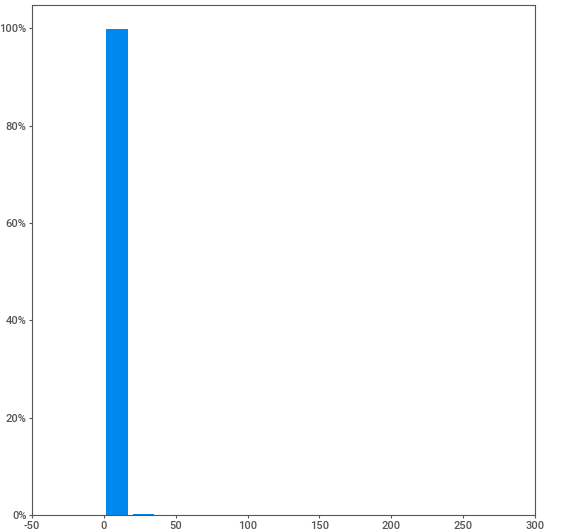
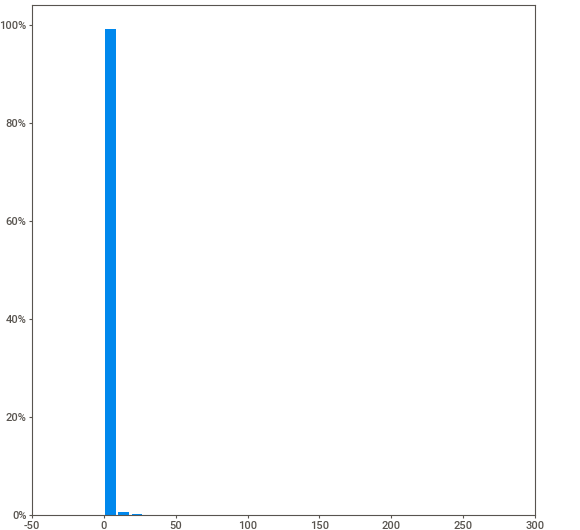
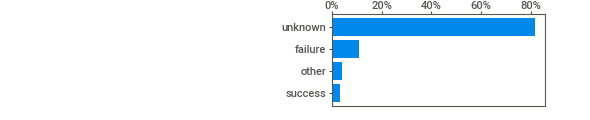
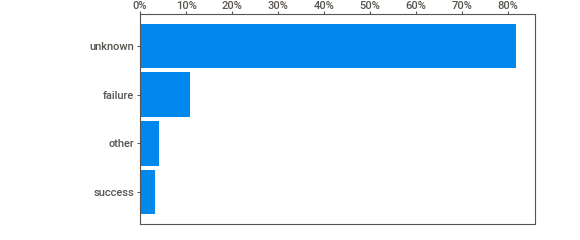
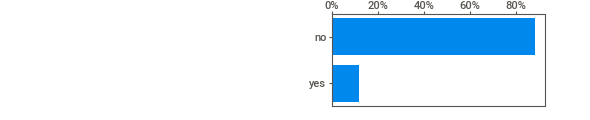
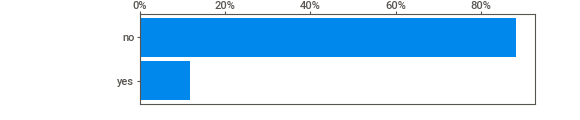
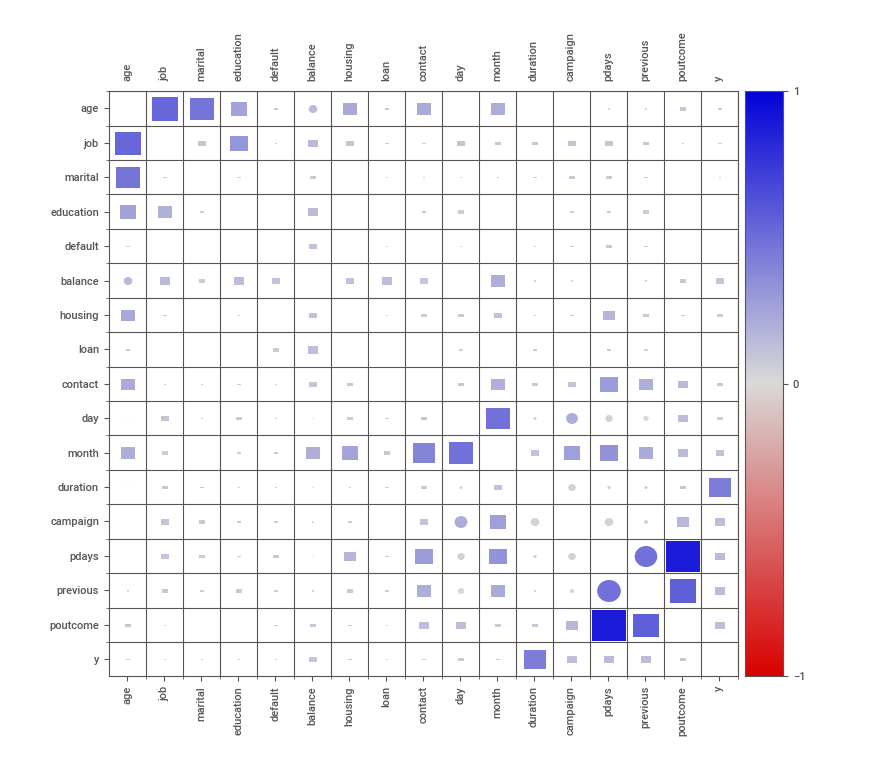
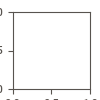

In [3]:
import sweetviz as sv

report = sv.analyze(df_bank_full)
report.show_notebook()

In [11]:
# Guardar el informe como un archivo HTML
report.show_html("informe_banco.html")

Report informe_banco.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


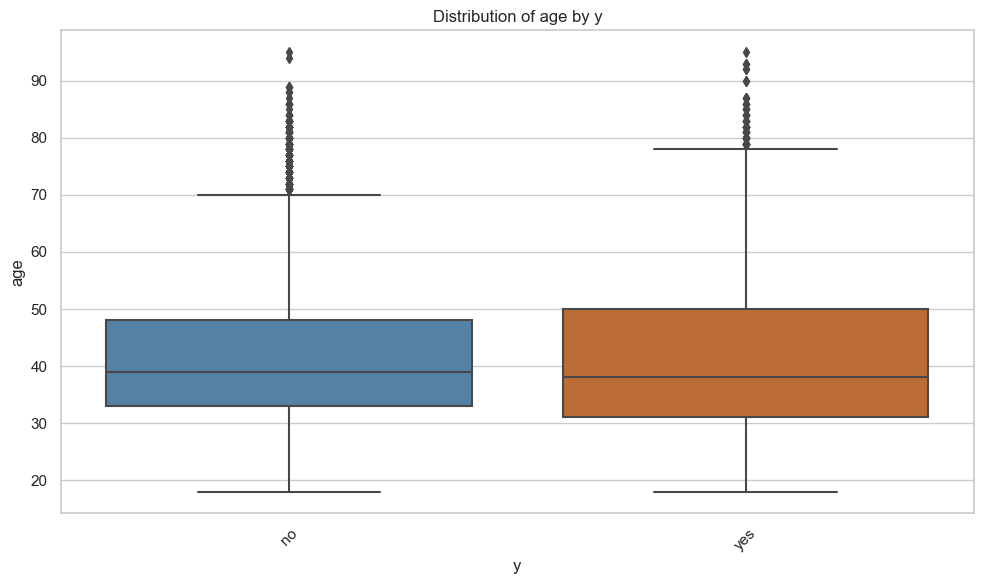

<Figure size 1000x600 with 0 Axes>

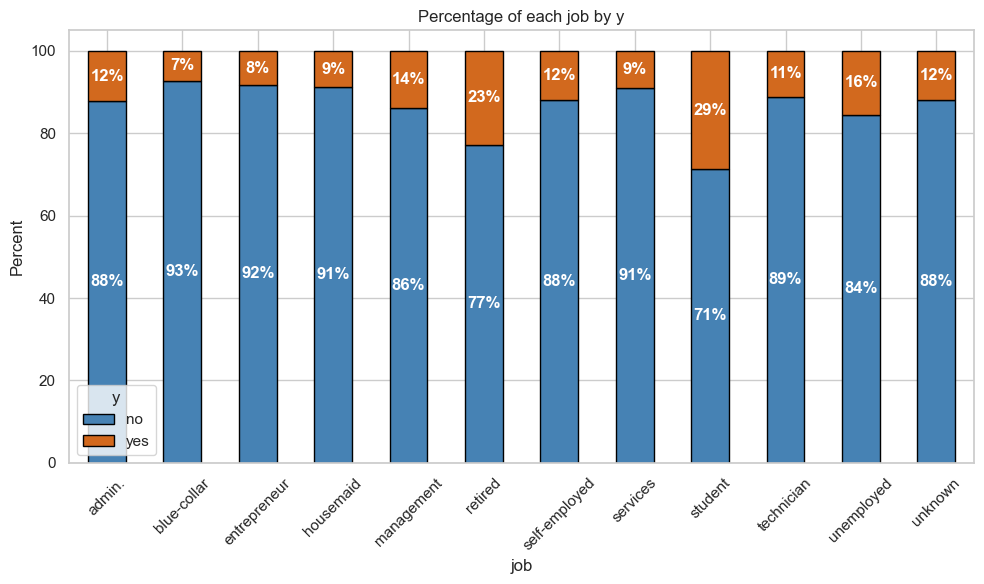

<Figure size 1000x600 with 0 Axes>

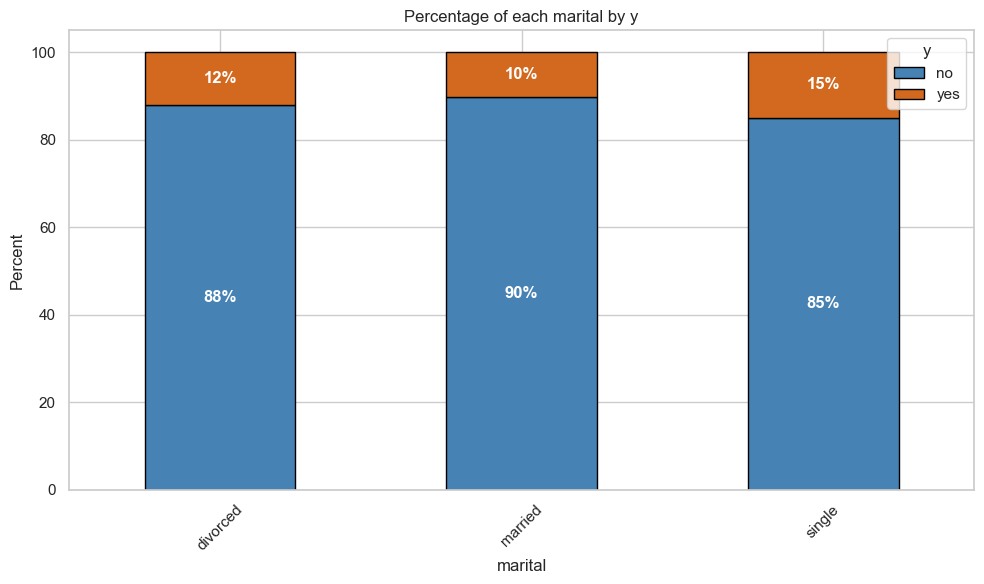

<Figure size 1000x600 with 0 Axes>

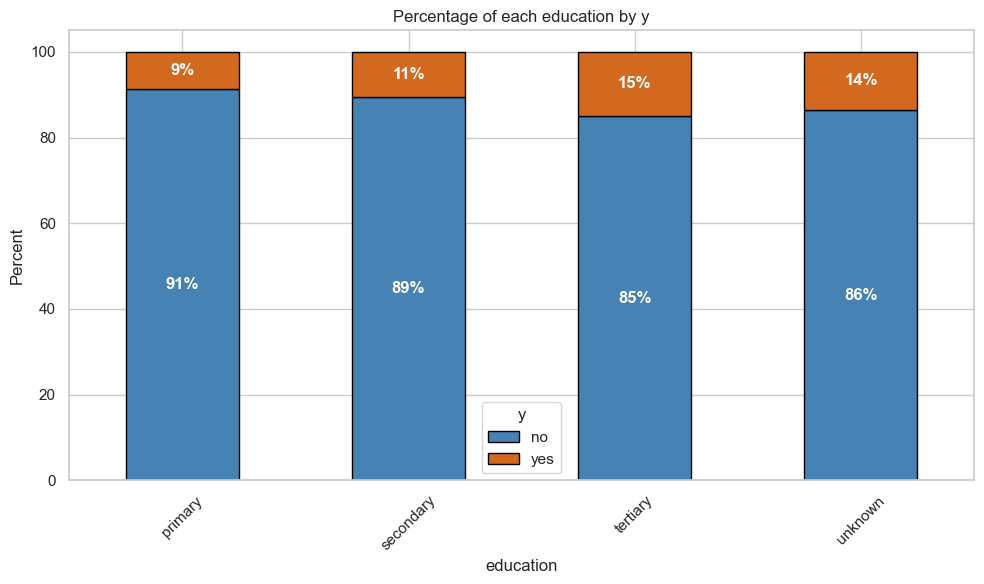

<Figure size 1000x600 with 0 Axes>

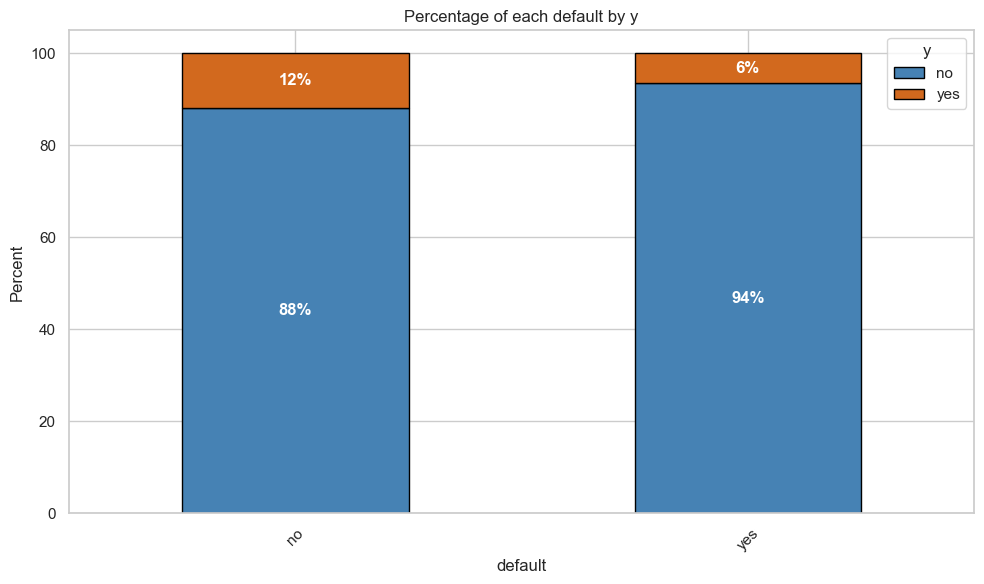

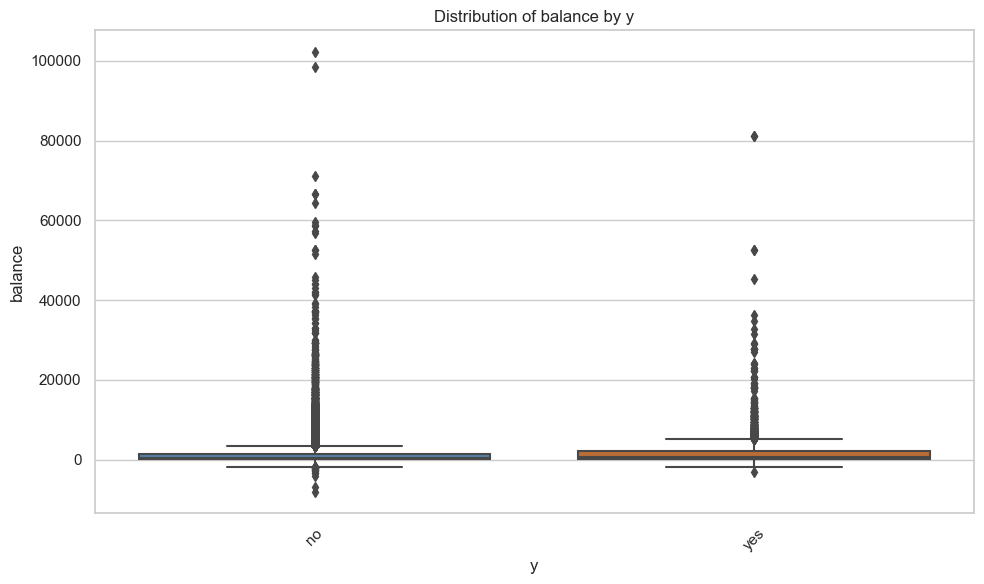

<Figure size 1000x600 with 0 Axes>

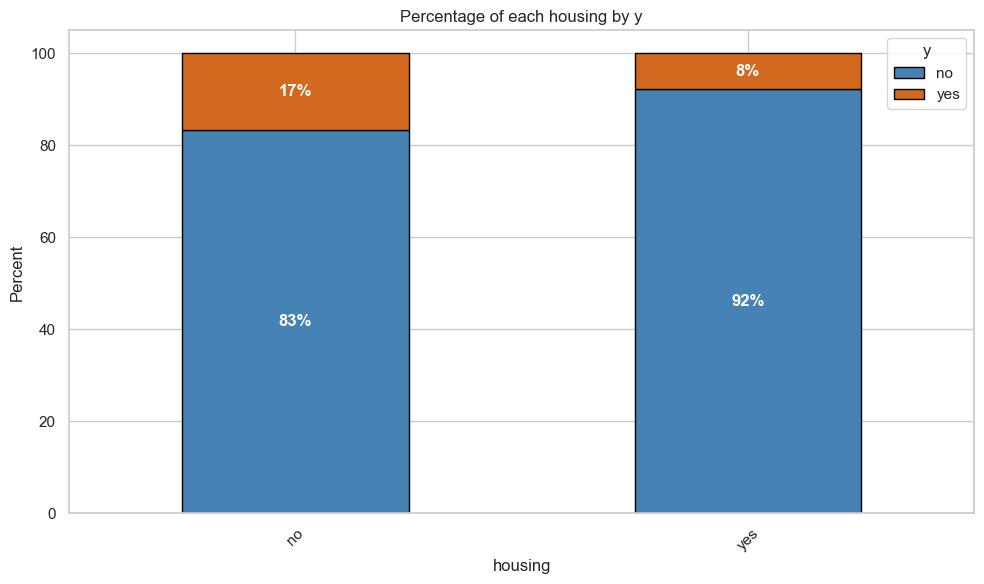

<Figure size 1000x600 with 0 Axes>

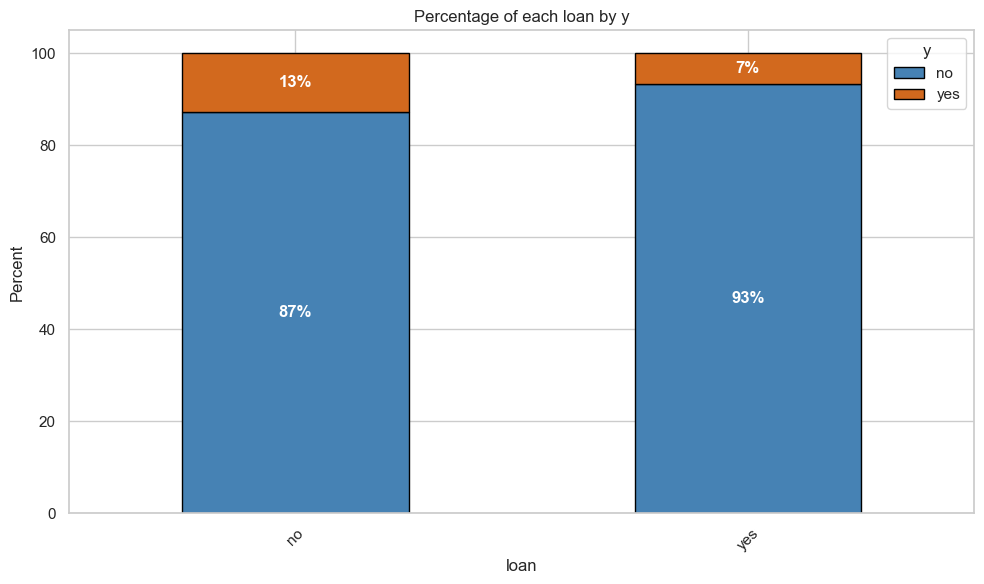

<Figure size 1000x600 with 0 Axes>

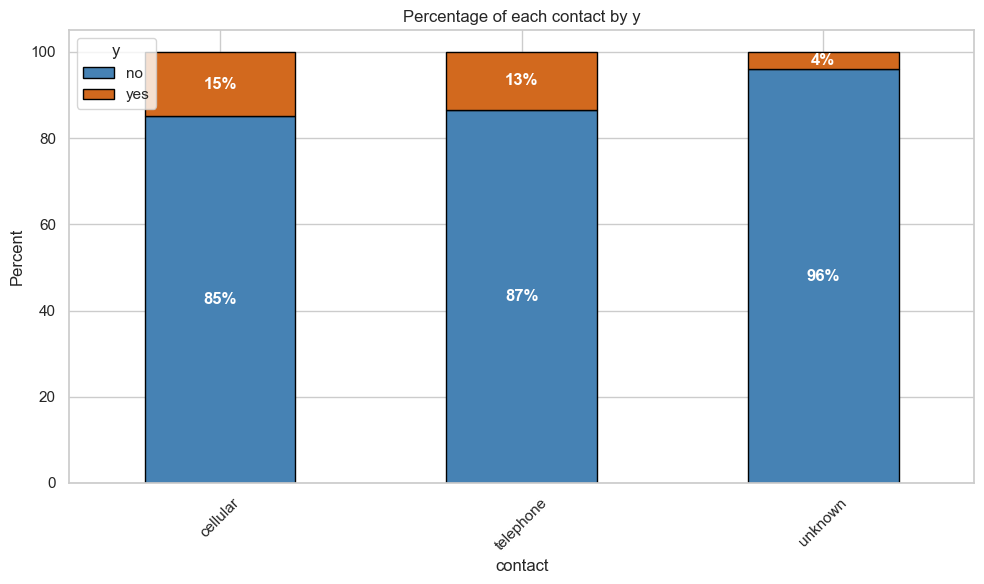

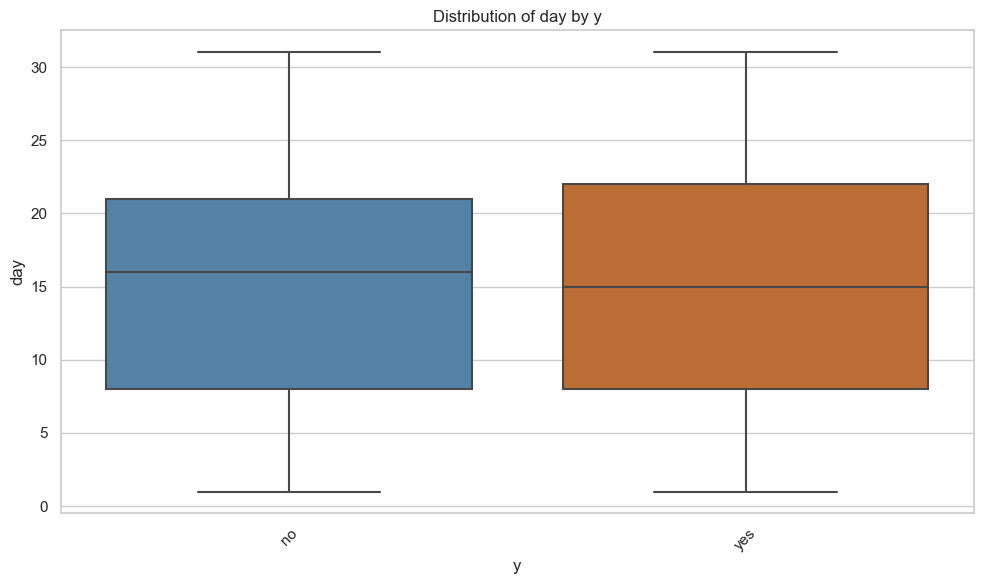

<Figure size 1000x600 with 0 Axes>

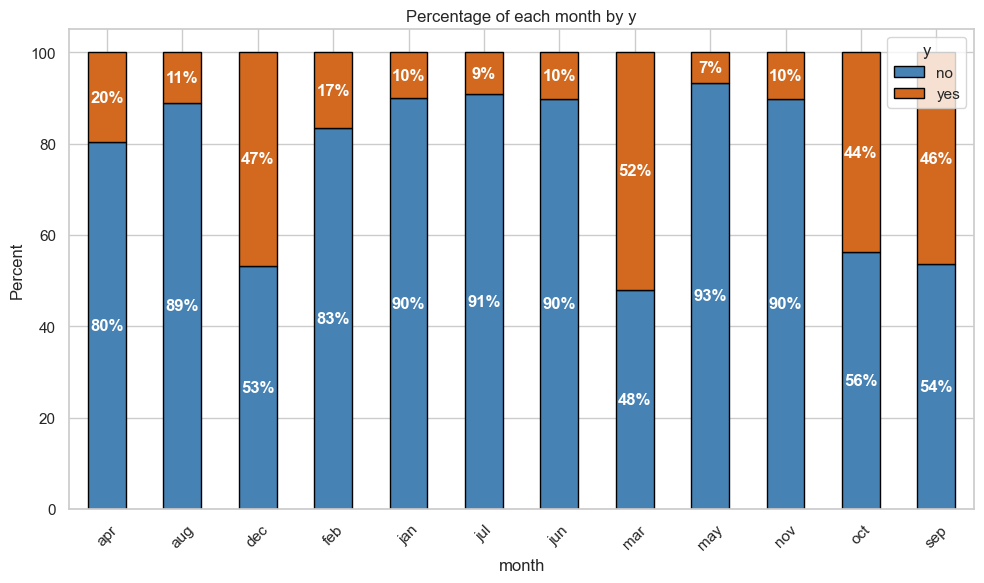

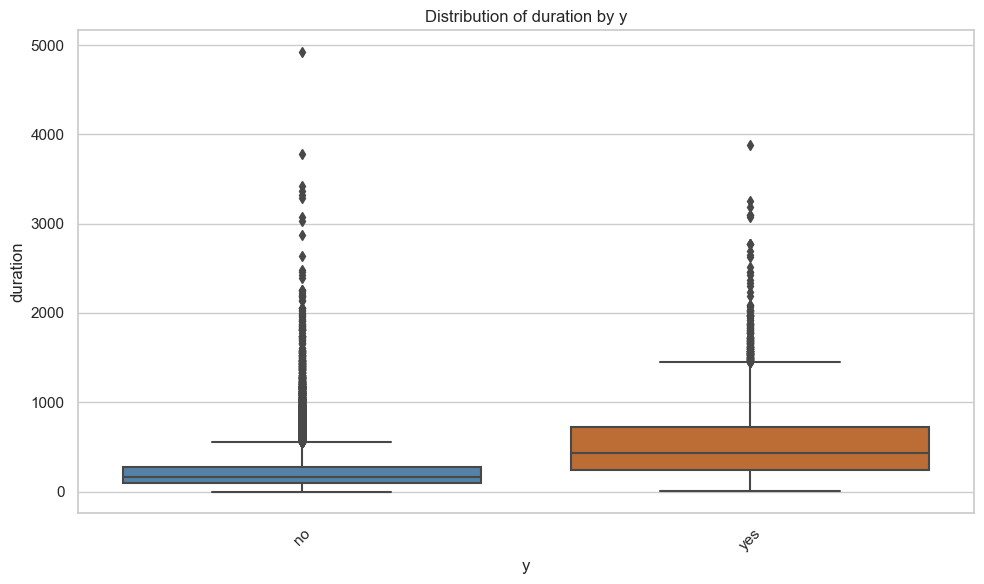

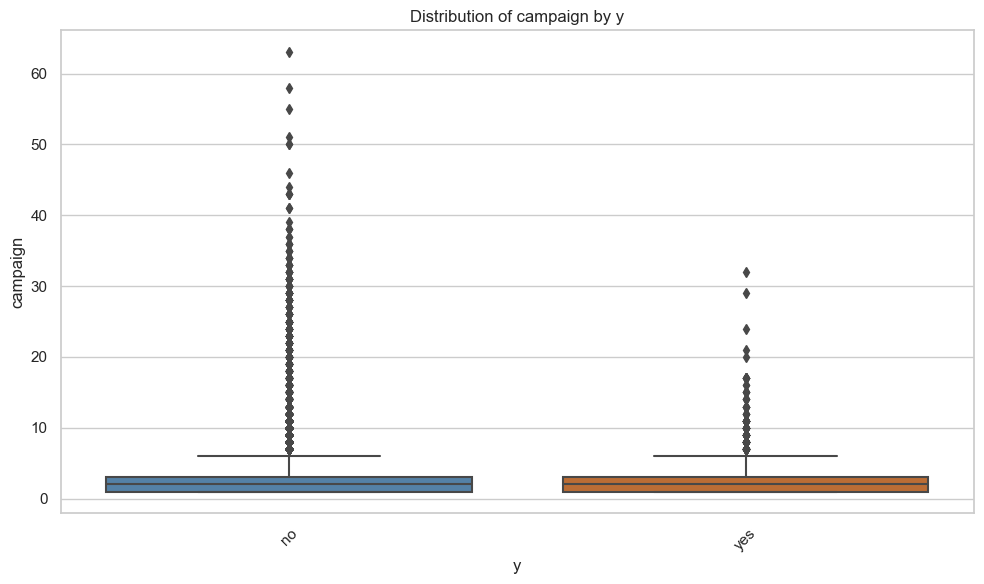

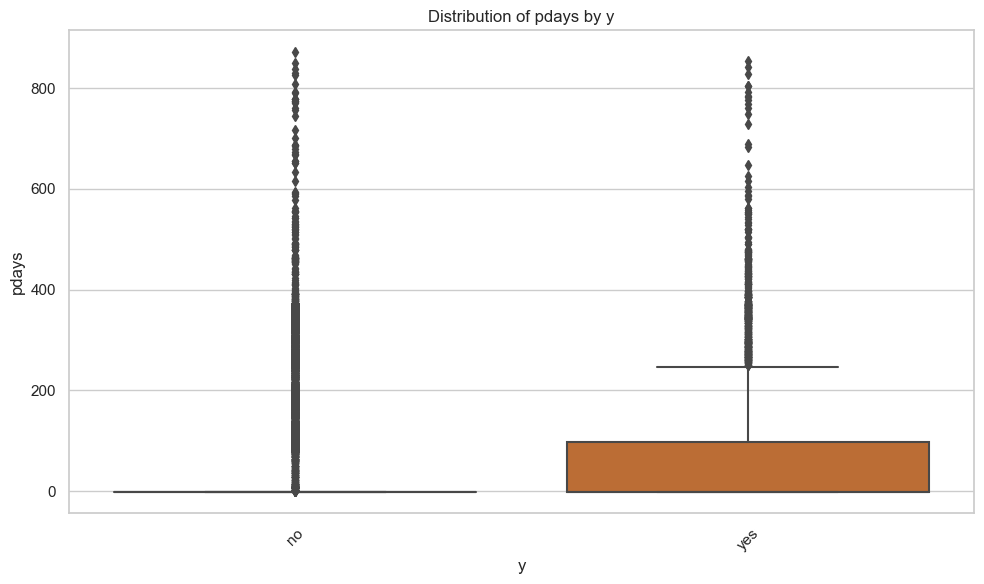

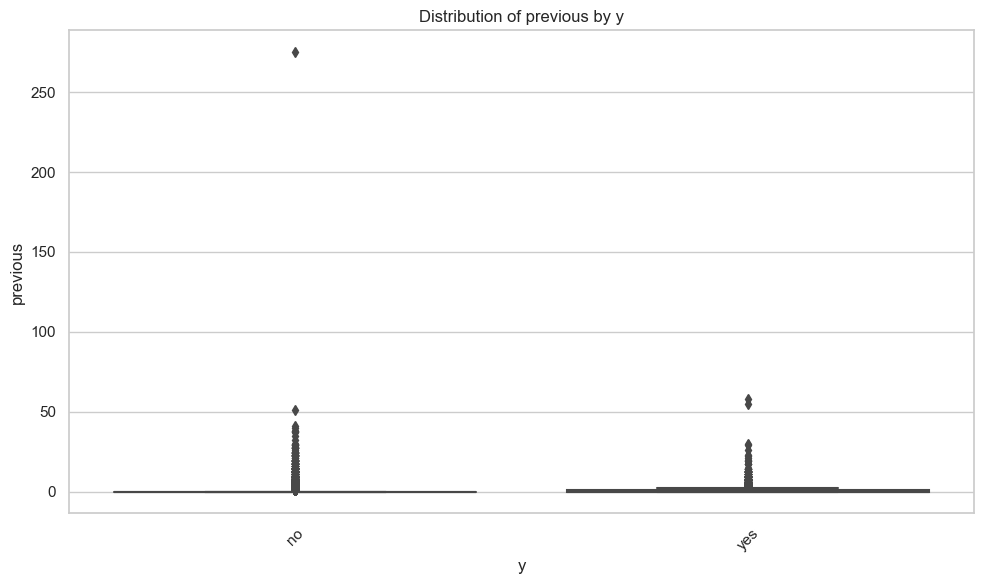

<Figure size 1000x600 with 0 Axes>

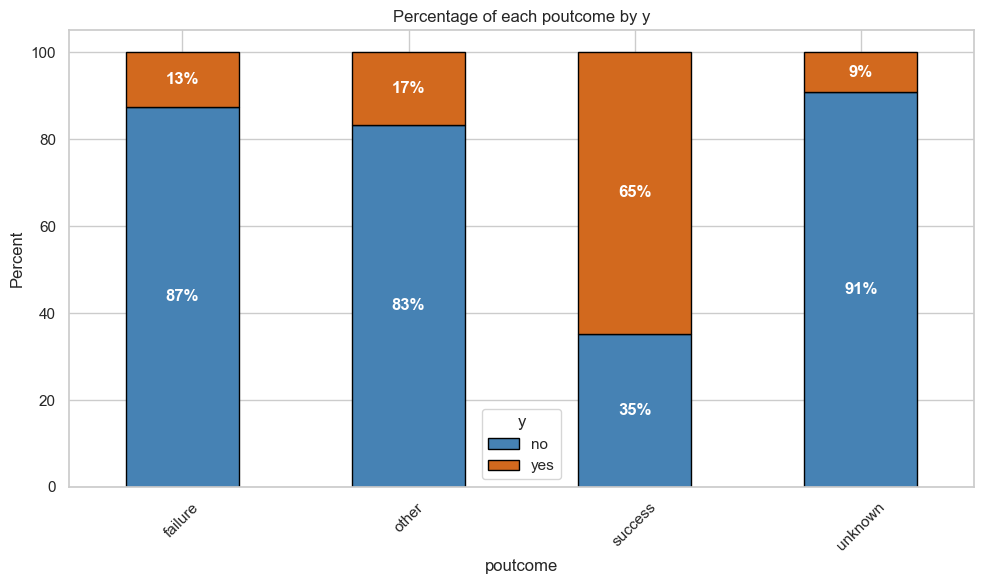

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Recorrer todas las columnas de df_bank_full excepto 'y'
for column in df_bank_full.drop('y', axis=1).columns:
    plt.figure(figsize=(10, 6))
    
    if df_bank_full[column].dtype == 'object':  # Si es categórica
        # Calcular proporciones
        data = df_bank_full.groupby([column, 'y']).size().unstack()
        data_percent = data.div(data.sum(axis=1), axis=0) * 100
        
        # Crear gráfico de barras apiladas con porcentajes
        ax = data_percent.plot(kind='bar', stacked=True, color=['#4682B4', '#D2691E'], edgecolor='black', figsize=(10, 6))
        plt.title(f'Percentage of each {column} by y')
        plt.ylabel('Percent')
        
        # Añadir etiquetas de porcentaje
        for i, (col_name, row) in enumerate(data_percent.iterrows()):
            cumulative = 0
            for j, (category, value) in enumerate(row.iteritems()):
                cumulative += value / 2
                if value > 0:  # Mostrar etiqueta solo si el valor es mayor a 0
                    ax.text(i, cumulative, f'{value:.0f}%', ha='center', va='center', color='white', fontweight='bold')
                cumulative += value / 2
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    else:  # Si es numérica
        # Crear gráfico de boxplot para variables numéricas
        sns.boxplot(data=df_bank_full, x='y', y=column, palette=['#4682B4', '#D2691E'])
        plt.title(f'Distribution of {column} by y')
        plt.ylabel(column)
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


### MODELADO

In [4]:
#!python -m pip install --upgrade pip==24.3.1
!pip install lazypredict==0.2.13

In [5]:
import lazypredict  
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Aplicar One-Hot Encoding a las columnas categóricas
X = df_bank_full.drop('y', axis=1)  # Excluye la columna objetivo 'y'
y = df_bank_full['y']  # Variable objetivo

# Convertir las variables categóricas a variables dummy
X_encoded = pd.get_dummies(X, drop_first=True)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Inicializar LazyClassifier 
clf = LazyClassifier(verbose=0, ignore_warnings=True) 

# Ajustar los modelos
models, results = clf.fit(X_train, X_test, y_train, y_test)

 97%|█████████▋| 28/29 [11:23<00:06,  6.03s/it] 

[LightGBM] [Info] Number of positive: 4198, number of negative: 31970
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1051
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116069 -> initscore=-2.030190
[LightGBM] [Info] Start training from score -2.030190


100%|██████████| 29/29 [11:24<00:00, 23.60s/it]


In [7]:
models


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.84,0.77,None,0.86,0.24
LGBMClassifier,0.91,0.73,None,0.90,0.61
QuadraticDiscriminantAnalysis,0.87,0.71,None,0.87,0.42
DecisionTreeClassifier,0.87,0.70,None,0.87,0.52
LinearDiscriminantAnalysis,0.90,0.70,None,0.89,0.93
PassiveAggressiveClassifier,0.87,0.70,None,0.87,0.26
GaussianNB,0.86,0.69,None,0.86,0.19
Perceptron,0.86,0.69,None,0.86,0.23
BaggingClassifier,0.90,0.69,None,0.89,2.36


In [4]:
!pip install scikit-learn imbalanced-learn scikit-optimize

In [3]:
from sklearn.model_selection import train_test_split

def preprocess_data(df, target_column='y', test_size=0.3, random_state=42):
    # Reemplazar los valores 'yes' por 1 y 'no' por 0 en la columna objetivo
    df[target_column] = df[target_column].replace({'yes': 1, 'no': 0})
    
    # Crear una nueva columna 'age_group' con rangos etarios para la variable 'age'
    df['age_group'] = pd.cut(df['age'], bins=[0, 18, 30, 45, 60, 100], 
                             labels=['0-18', '19-30', '31-45', '46-60', '61+'])
    
    # Eliminar la columna original 'age'
    df = df.drop(columns=['age'])
    
    # Separar las variables predictoras (X) y la variable objetivo (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Seleccionar solo las columnas categóricas
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns
    
    # Aplicar One Hot Encoding solo a las columnas categóricas
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
    
    # Dividir el dataset en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test


In [7]:
# Usar la función con tu DataFrame
X_train, X_test, y_train, y_test = preprocess_data(df=df_bank_full, target_column='y')

In [6]:
!pip install scikit-optimize

## Funcion probar modelos

In [5]:
from skopt import BayesSearchCV
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def optimize_model(model, param_space, X_train, y_train, n_iter=32, scoring='f1', cv=3, n_jobs=-1, random_state=42):
    """
    Función para optimizar un modelo utilizando optimización bayesiana.

    model: el modelo de machine learning (SVC, LightGBM, RandomForest, etc.)
    param_space: espacio de búsqueda para los hiperparámetros
    X_train: conjunto de entrenamiento
    y_train: etiquetas del conjunto de entrenamiento
    n_iter: número de iteraciones para la optimización
    scoring: métrica de evaluación
    cv: número de pliegues en la validación cruzada
    n_jobs: número de núcleos a usar para la optimización
    random_state: semilla aleatoria

    Returns: modelo optimizado y su mejor puntaje
    """
    # Configurar la búsqueda bayesiana de hiperparámetros
    opt = BayesSearchCV(
        model,
        param_space,
        n_iter=n_iter,             # número de iteraciones para la optimización
        scoring=scoring,          # métrica de evaluación
        cv=cv,                    # número de pliegues en la validación cruzada
        random_state=random_state,
        n_jobs=n_jobs              # utiliza todos los núcleos disponibles
    )

    # Ejecutar la optimización
    opt.fit(X_train, y_train)
    
    # Imprimir los mejores parámetros y el puntaje
    print("Best Parameters:", opt.best_params_)
    print("Best Score:", opt.best_score_)
    
    return opt.best_estimator_

In [ ]:
# Ejemplo de uso para Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_param_space = {
    'n_estimators': (10, 200),               # número de árboles
    'max_depth': (1, 20),                    # profundidad máxima
    'min_samples_split': (2, 10),            # mínimo de muestras para dividir un nodo
    'min_samples_leaf': (1, 10)              # mínimo de muestras en una hoja
}

best_rf_model = optimize_model(rf_model, rf_param_space, X_train, y_train)



Best Parameters: OrderedDict([('max_depth', 19), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 14)])
Best Score: 0.4661853166164273


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Ver los mejores parámetros del modelo optimizado
print("Mejores parámetros del modelo optimizado:", best_rf_model.get_params())

# Probar el modelo optimizado en el conjunto de prueba
y_pred = best_rf_model.predict(X_test)
test_score = best_rf_model.score(X_test, y_test)

print("F1 Score en el conjunto de prueba:", test_score)

# Calcular el accuracy en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy en el conjunto de prueba:", test_accuracy)

Mejores parámetros del modelo optimizado: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 14, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Test Score: 0.9017988793866116
F1 Score en el conjunto de prueba: 0.9017988793866116
Accuracy en el conjunto de prueba: 0.9017988793866116


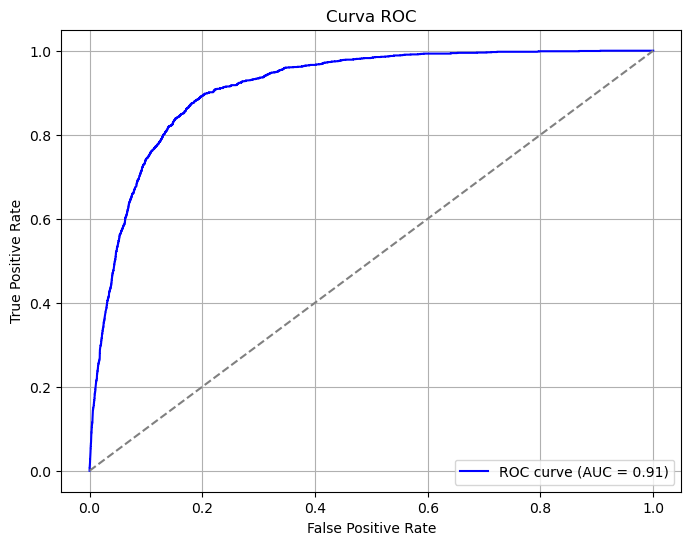

AUC-ROC Score: 0.9139349401945478


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Obtener las probabilidades de predicción del modelo para la clase positiva
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print("AUC-ROC Score:", roc_auc)


In [ ]:
# Ejemplo de uso para LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_param_space = {
    'num_leaves': (31, 58),          # número de hojas
    'max_depth': (5, 10),             # profundidad máxima
    'learning_rate': (0.001, 0.1),    # tasa de aprendizaje
    'n_estimators': (10, 50),       # número de árboles
}

best_lgb_model = optimize_model(lgb_model, lgb_param_space, X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3691, number of negative: 27956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 31647, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116630 -> initscore=-2.024734
[LightGBM] [Info] Start training from score -2.024734
Best Parameters: OrderedDict([('learning_rate', 0.1), ('max_depth', 9), ('n_estimators', 50), ('num_leaves', 31)])
Best Score: 0.5363629458908213


In [18]:
# Ver los mejores parámetros del modelo optimizado
print("Mejores parámetros del modelo optimizado:", best_lgb_model.get_params())

# Probar el modelo optimizado en el conjunto de prueba
y_pred = best_lgb_model.predict(X_test)

test_score = best_rf_model.score(X_test, y_test)

print("F1 Score en el conjunto de prueba:", test_score)

# Calcular el accuracy en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy en el conjunto de prueba:", test_accuracy)

Mejores parámetros del modelo optimizado: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
F1 Score en el conjunto de prueba: 0.9017988793866116
Accuracy en el conjunto de prueba: 0.9065909761132409


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


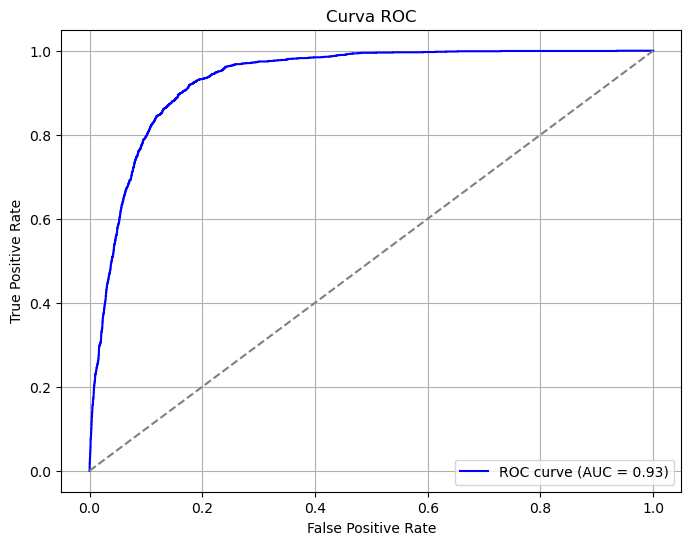

AUC-ROC Score: 0.9331064633064439


In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Obtener las probabilidades de predicción del modelo para la clase positiva
y_prob = best_lgb_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print("AUC-ROC Score:", roc_auc)

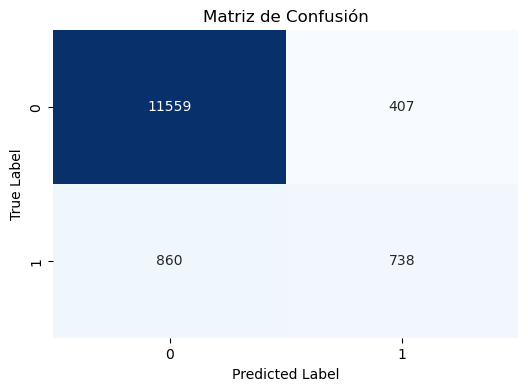

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()


In [21]:
# Obtener las importancias de las características
feature_importances = best_lgb_model.feature_importances_

# Asumiendo que tienes una lista de los nombres de las características
# Por ejemplo, si tus características están en un DataFrame llamado X_train:
feature_names = X_train.columns

# Crear un DataFrame para visualizar la importancia
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Imprimir el top 10 de las características más importantes
print("Top 10 características más importantes:")
print(importance_df.head(10))

Top 10 características más importantes:
             Feature  Importance
2           duration         285
1                day         182
4              pdays         128
0            balance         102
26   contact_unknown          55
27         month_aug          51
31         month_jul          49
3           campaign          48
34         month_may          47
39  poutcome_success          45


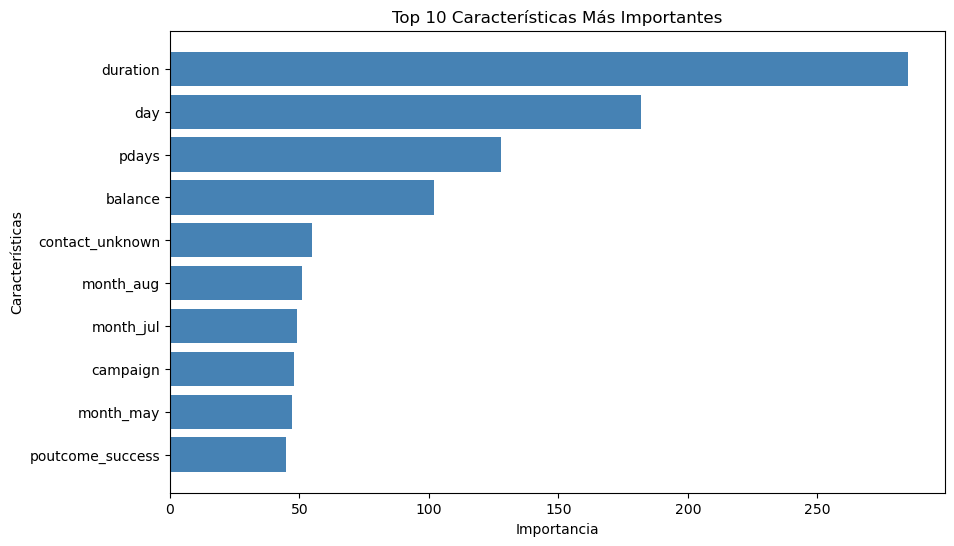

In [22]:
# Visualizar las importancias en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='steelblue')
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Top 10 Características Más Importantes")
plt.show()